In [1]:
import numpy as np
import matplotlib.pyplot as plt
from core import polarFitFuncv2
import imageio
import scipy.io
import re
from scipy.io import savemat
import os


In [2]:

filename='Image_ITtheory_10000_r_5p1_w_51_wGen_51_bg_10_delta_140_rho_030_eta_000_lambda_0.6_f_0_z_0_All_PoissonNoise.mat'


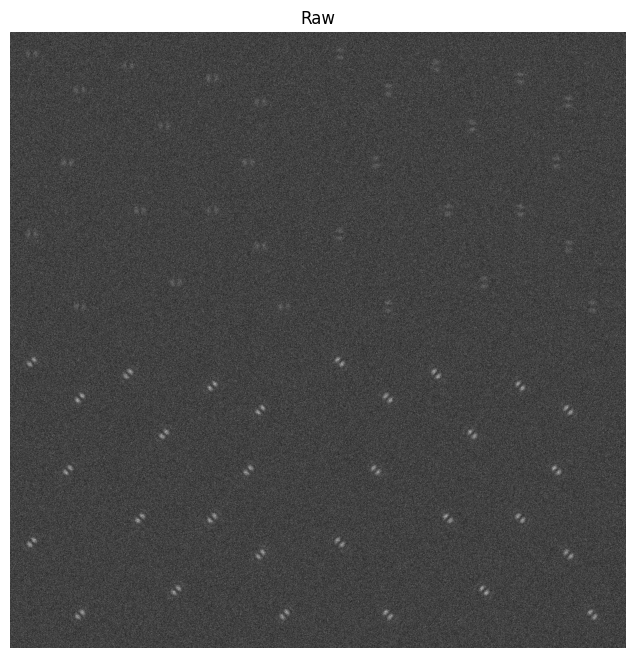

In [3]:
dir_='D:/IHB2023/Collaborations/4polar/Simulation-3Dpolar_v3/Synthetic_images_oversampled/'
dir0=dir_+'Data/'
output_dir=dir_+'Output/'
fig_dir=dir_+'Figs/'


if not os.path.exists(dir0):
    os.makedirs(dir0) 

if not os.path.exists(output_dir):
    os.makedirs(output_dir) 

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)


thresh = 20
threshDist=30
min_distance=50
window_size=51

#thresh = 600
#min_distance=2
#threshDist=2

matchdelta = re.search(r'delta_(\d+)', filename)
delta_teo=int(matchdelta.group(1))


matchrho = re.search(r'rho_(\d+)', filename)
rho_teo=int(matchrho.group(1))


matcheta = re.search(r'eta_(\d+)', filename)
eta_teo=int(matcheta.group(1))



K = np.array([[2.1352,0.0272,0.5739,0.0000],
                  [0.0272,2.1352,0.5739,0.0000],
                  [1.6370,1.6370,1.5597,2.9702],
                  [1.6370,1.6370,1.5597,-2.9702]])


# Load the MAT file
mat = scipy.io.loadmat(dir0+filename)
tif_array= mat['Img2x2']

#print(tif_array.shape)

deltaij=tif_array.shape[1]/2

img_arr = tif_array[1,:,:]

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(img_arr, cmap='gray')
ax.set_title('Raw')
ax.axis('off')
plt.show()

num_imgs=10
#tif_array.shape[0]

#print('Number of images: ' + str(num_imgs))

In [4]:
from joblib import Parallel, delayed, cpu_count

from tqdm import tqdm 

parallelflag=True
num_cores =cpu_count()


print("Number of CPU cores:", num_cores)


def process_image(i):
    img_arr = tif_array[i,:,:]
    flagplot = False
    return polarFitFuncv2.fitting4polar(img_arr, thresh, min_distance, window_size, PSFmodel,flagplot)


output_Fit4_1G = {}
output_Fit4_2G = {}
output_Fit4_intWn = {}
results2G={}
results1G={}
resultsintWn={}

if parallelflag:
    print('Parallel processing')
    
    PSFmodel='2Dgaussian'
    results2G = Parallel(n_jobs=num_cores)(delayed(process_image)(i) for i in tqdm(range(num_imgs)))
    
    PSFmodel='1Dgaussian'
    results1G = Parallel(n_jobs=num_cores)(delayed(process_image)(i) for i in tqdm(range(num_imgs)))

    PSFmodel='intwindow'
    resultsintWn = Parallel(n_jobs=num_cores)(delayed(process_image)(i) for i in tqdm(range(num_imgs)))

    for i, result in enumerate(results1G):
        output_Fit4_1G[i] = result
    
    for i, result in enumerate(results2G):
        output_Fit4_2G[i] = result
    
    for i, result in enumerate(resultsintWn):
        output_Fit4_intWn[i] = result

else: 
    flagplot=False
    for i in range(num_imgs):
        img_arr = tif_array[i,:,:]       
        output_Fit4_1G[i]=polarFitFuncv2.fitting4polar(img_arr,thresh,min_distance,window_size,'1Dgaussian',flagplot)
        output_Fit4_2G[i]=polarFitFuncv2.fitting4polar(img_arr,thresh,min_distance,window_size,'2Dgaussian',flagplot)
        output_Fit4_intWn[i]=polarFitFuncv2.fitting4polar(img_arr,thresh,min_distance,window_size,'intwindow',flagplot)


Number of CPU cores: 16
Parallel processing


100%|██████████| 10/10 [00:00<?, ?it/s]


In [5]:
flagplot2=False
Results1G=[]
Results2G=[]
ResultsintWn=[]

Resultstemp1G=[]
Resultstemp2G=[]
ResultstempintWn=[]

for i in range(num_imgs):
    Resultstemp1G=polarFitFuncv2.registration4polar(flagplot2,threshDist,img_arr,output_Fit4_1G[i],deltaij)
    Resultstemp2G=polarFitFuncv2.registration4polar(flagplot2,threshDist,img_arr,output_Fit4_2G[i],deltaij)
    ResultstempintWn=polarFitFuncv2.registration4polar(flagplot2,threshDist,img_arr,output_Fit4_intWn[i],deltaij)
    
    Results1G.append(Resultstemp1G)
    Results2G.append(Resultstemp2G)
    ResultsintWn.append(ResultstempintWn)


Results1G = np.concatenate(Results1G, axis=0)
Results2G = np.concatenate(Results2G, axis=0)
ResultsintWn= np.concatenate(ResultsintWn, axis=0)

delta_all1G, rho_all1G, eta_all1G=polarFitFuncv2.Fcn_dg_4x4_modif_3D_07122022(Results1G[:,2], Results1G[:,16], Results1G[:,9], Results1G[:,23],K)
delta_all2G, rho_all2G, eta_all2G=polarFitFuncv2.Fcn_dg_4x4_modif_3D_07122022(Results2G[:,2], Results2G[:,16], Results2G[:,9], Results2G[:,23],K)
delta_allintWn, rho_allintWn, eta_allintWn=polarFitFuncv2.Fcn_dg_4x4_modif_3D_07122022(ResultsintWn[:,2], ResultsintWn[:,16], ResultsintWn[:,9], ResultsintWn[:,23],K)

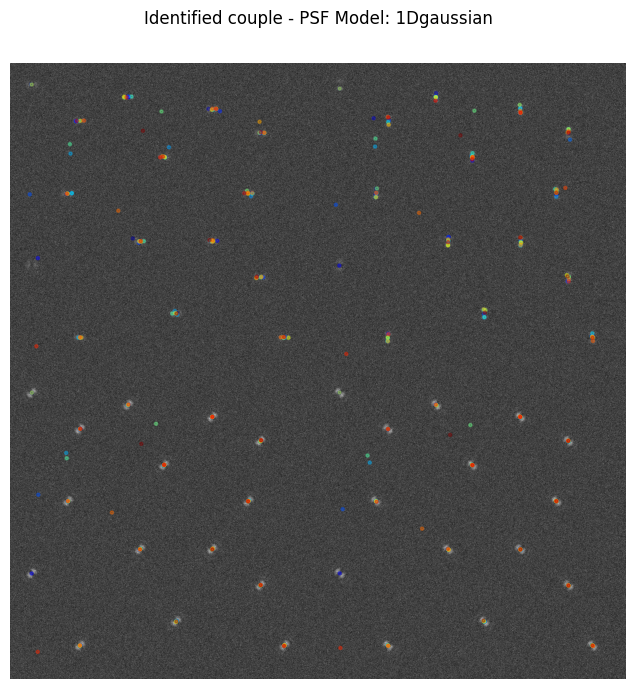

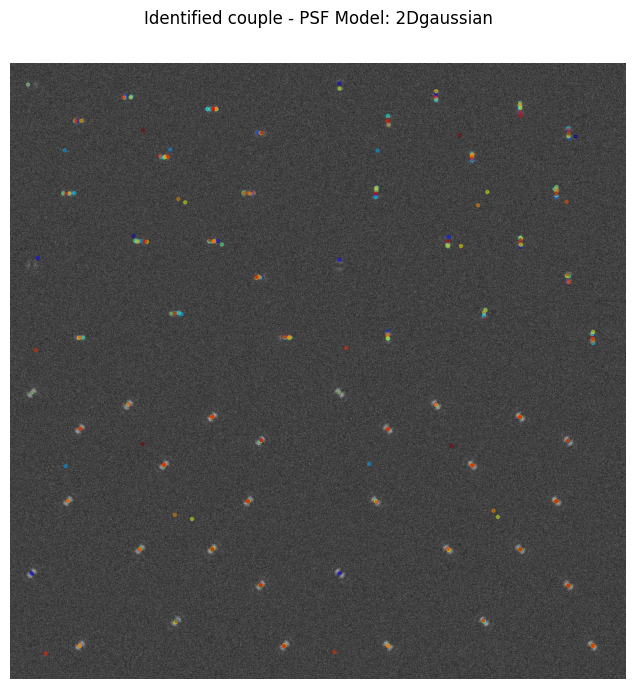

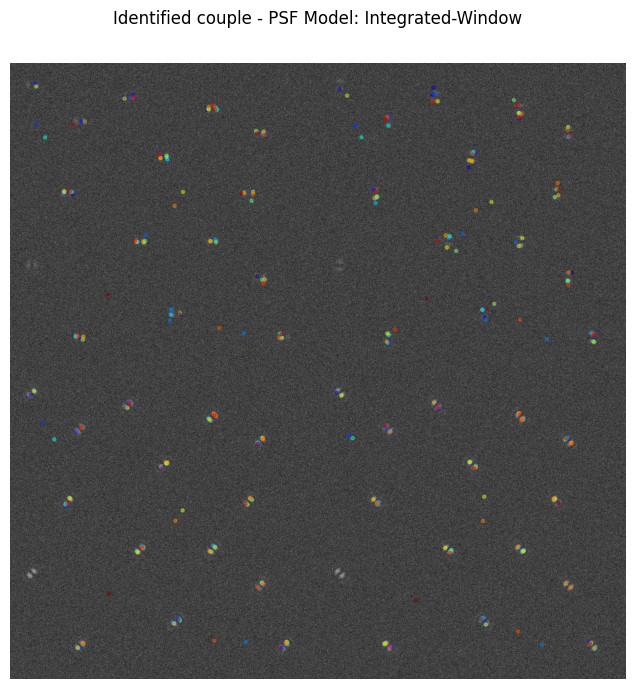

In [6]:
def plotfinalfigure(img_arr,Results,modeltxt,fig_dir,filename):
     num_spots=Results.shape[0]
     rgb_range=np.linspace(0,1,num_spots)
     rgb_vals=plt.cm.jet(rgb_range)
     #Plot the image and the identified peak
     
     fig, ax = plt.subplots(figsize=(8,8))
     ax.imshow(img_arr, cmap='gray')
     ax.scatter(Results[:,0], Results[:,1], c=rgb_vals, marker='o', s=5,alpha=0.4)
     ax.scatter(Results[:,7], Results[:,8], c=rgb_vals, marker='o', s=5,alpha=0.4)
     ax.scatter(Results[:,14], Results[:,15], c=rgb_vals, marker='o', s=5,alpha=0.4)
     ax.scatter(Results[:,21], Results[:,22], c=rgb_vals, marker='o', s=5,alpha=0.4)
     #ax.set_title('Identified couple')
     ax.set_title("Identified couple - PSF Model: "+modeltxt,y=1.05)
     ax.axis('off')
     plt.show()
     
     base_name = os.path.splitext(filename)[0]
     figname = base_name + '_'+modeltxt+'_IdentifiedCouples.png'
     fig.savefig(fig_dir+figname)


plotfinalfigure(img_arr,Results1G,'1Dgaussian',fig_dir,filename)
plotfinalfigure(img_arr,Results2G,'2Dgaussian',fig_dir,filename)
plotfinalfigure(img_arr,ResultsintWn,'Integrated-Window',fig_dir,filename)

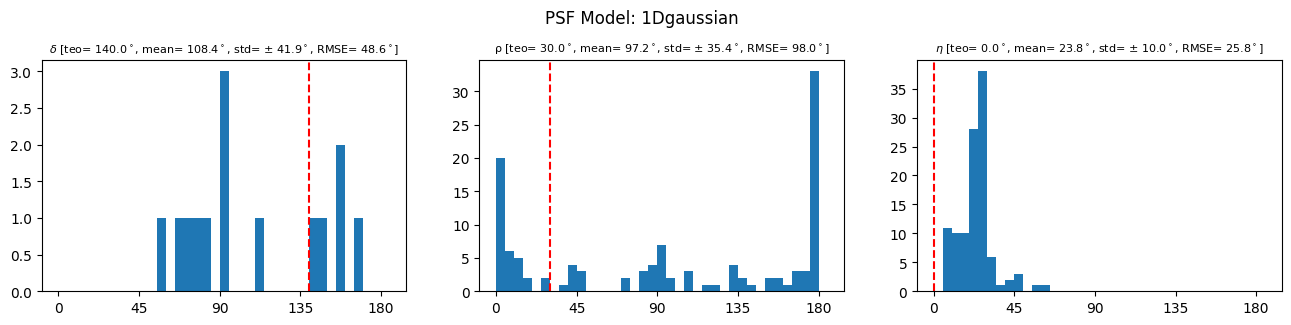

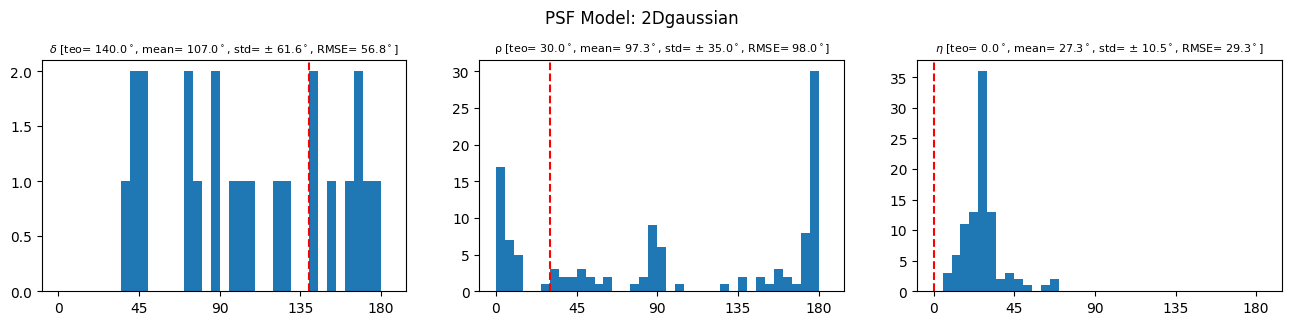

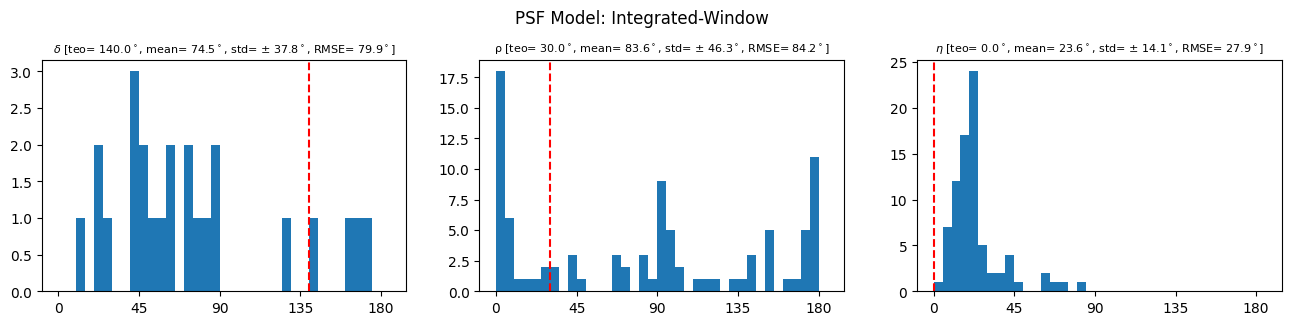

In [7]:
from scipy.stats import circstd

def plotResults(delta_teo,rho_teo,eta_teo,delta_all,rho_all,eta_all,PSFmodel,fig_dir,filename):
    meaneta=np.nanmean(eta_all*180/np.pi)
    meanrho=np.nanmean(rho_all*180/np.pi)
    meandelta=np.nanmean(delta_all*180/np.pi)

    stdeta=circstd(eta_all*180/np.pi,high=180,low=0,nan_policy='omit')
    stdrho=circstd(rho_all*180/np.pi,high=180,low=0,nan_policy='omit')
    stddelta=circstd(delta_all*180/np.pi,high=180,low=0,nan_policy='omit')

    RMSEeta =np.sqrt(np.nanmean([(eta_teo - real_value)**2 for real_value in eta_all*180/np.pi]))
    RMSErho =np.sqrt(np.nanmean([(rho_teo - real_value)**2 for real_value in rho_all*180/np.pi]))
    RMSEdelta =np.sqrt(np.nanmean([(delta_teo - real_value)**2 for real_value in delta_all*180/np.pi]))

    eta_nan = np.count_nonzero(np.isnan(eta_all))
    rho_nan = np.count_nonzero(np.isnan(rho_all))
    delta_nan = np.count_nonzero(np.isnan(delta_all))

    #print(r"nans delta: {:.0f} / {:.0f}".format(delta_nan,delta_all.shape[0]))
    # print(r"nans rho: {:.0f} / {:.0f}"  .format(rho_nan,rho_all.shape[0]))
    # print(r"nans eta: {:.0f} / {:.0f}".format(eta_nan,eta_all.shape[0]))

    xticks = np.linspace(0, 180, 5)
    fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(16,3))

    ax[0].hist(delta_all*180/np.pi,bins=range(0,190,5))
    ax[0].set_title('$\delta$ [teo= {:.1f}$^\circ$, mean= {:.1f}$^\circ$, std= \u00B1 {:.1f}$^\circ$, RMSE= {:.1f}$^\circ$]'.format(delta_teo, meandelta,stddelta,RMSEdelta),fontsize=8)
    ax[0].set_xticks(xticks)
    ax[0].axvline(x=delta_teo,color='red',linestyle='--')

    ax[1].hist(rho_all*180/np.pi,bins=range(0,190,5))
    ax[1].set_title('\u03C1 [teo= {:.1f}$^\circ$, mean= {:.1f}$^\circ$, std= \u00B1 {:.1f}$^\circ$, RMSE= {:.1f}$^\circ$]'.format(rho_teo, meanrho,stdrho,RMSErho),fontsize=8)
    ax[1].set_xticks(xticks)
    ax[1].axvline(x=rho_teo,color='red',linestyle='--')
    
    ax[2].hist(eta_all*180/np.pi,bins=range(0,190,5))
    ax[2].set_title('$\eta$ [teo= {:.1f}$^\circ$, mean= {:.1f}$^\circ$, std= \u00B1 {:.1f}$^\circ$, RMSE= {:.1f}$^\circ$]'.format(eta_teo, meaneta,stdeta,RMSEeta),fontsize=8)
    ax[2].set_xticks(xticks)
    ax[2].axvline(x=eta_teo,color='red',linestyle='--')
    
    fig.suptitle("PSF Model: "+PSFmodel,y=1.05)
    
    plt.show()

    base_name = os.path.splitext(filename)[0]
    figname = base_name + '_'+PSFmodel+'.png'
    fig.savefig(fig_dir+figname,bbox_inches='tight')


plotResults(delta_teo,rho_teo,eta_teo,delta_all1G, rho_all1G, eta_all1G,'1Dgaussian',fig_dir,filename)
plotResults(delta_teo,rho_teo,eta_teo,delta_all2G, rho_all2G, eta_all2G,'2Dgaussian',fig_dir,filename)
plotResults(delta_teo,rho_teo,eta_teo,delta_allintWn, rho_allintWn,eta_allintWn,'Integrated-Window',fig_dir,filename)


In [8]:
#print(max(rho_all1G)*180/np.pi)

## Save mat file

In [9]:


totalInt1G=Results1G[:,2]+Results1G[:,16]+Results1G[:,9]+Results1G[:,23]
totalInt2G=Results2G[:,2]+Results2G[:,16]+Results2G[:,9]+Results2G[:,23]
totalIntintWn=ResultsintWn[:,2]+ResultsintWn[:,16]+ResultsintWn[:,9]+ResultsintWn[:,23]

Results1Gmat=np.concatenate((Results1G,np.expand_dims(delta_all1G,axis=1),np.expand_dims(rho_all1G,axis=1),np.expand_dims(eta_all1G,axis=1),np.expand_dims(totalInt1G,axis=1)),axis=1)
Results2Gmat=np.concatenate((Results2G,np.expand_dims(delta_all2G,axis=1),np.expand_dims(rho_all2G,axis=1),np.expand_dims(eta_all2G,axis=1),np.expand_dims(totalInt2G,axis=1)),axis=1)
ResultsintWnGmat=np.concatenate((ResultsintWn,np.expand_dims(delta_allintWn,axis=1),np.expand_dims(rho_allintWn,axis=1),np.expand_dims(eta_allintWn,axis=1),np.expand_dims(totalIntintWn,axis=1)),axis=1)

data={
    'Results1G':Results1Gmat,
    'Results2G':Results2Gmat,
    'ResultsintWn':ResultsintWnGmat,
    'delta_teo':delta_teo,
    'rho_teo':rho_teo,
    'eta_teo':eta_teo,
    'thresh':thresh,
    'min_distance':min_distance,
    'window_size':window_size,
    'threshDist':threshDist,
    'filename':filename
}

base_name = os.path.splitext(filename)[0]

# Create the new file name with the .mat extension
mat_file = base_name + '_Results.mat'


savemat(output_dir+mat_file,data)


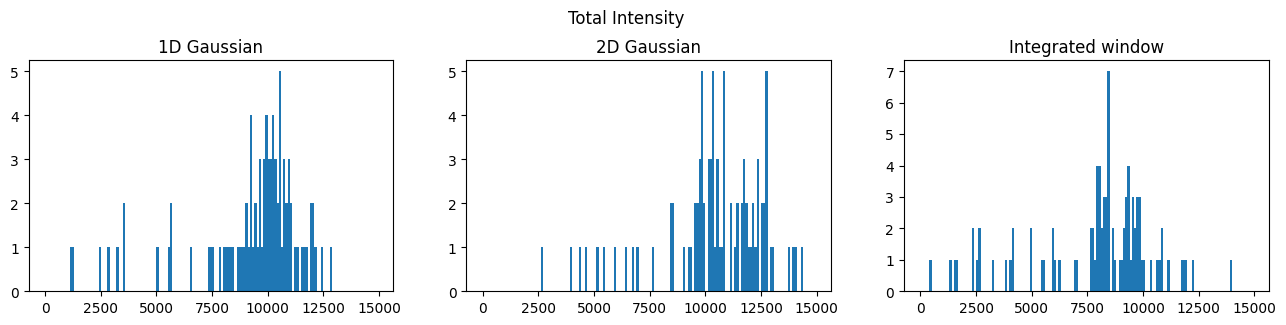

(117,)


In [10]:
    
def plotIntensity(totalInt1G,totalInt2G,totalIntintWn,fig_dir,filename):

    maxVal=15000
    xticks = np.linspace(0, maxVal,10)
    binsInt=range(0, maxVal,100)

    fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(16,3))

    ax[0].hist(totalInt1G,bins=binsInt)
    
    ax[0].set_title('1D Gaussian')

    ax[1].hist(totalInt2G,bins=binsInt)
    ax[1].set_title('2D Gaussian')
    
    ax[2].hist(totalIntintWn,bins=binsInt)
    ax[2].set_title('Integrated window')
    
    fig.suptitle("Total Intensity ",y=1.05)
    
    plt.show()
    base_name = os.path.splitext(filename)[0]
    figname = base_name + '_TotalIntensity.png'
    fig.savefig(fig_dir+figname,bbox_inches='tight')


plotIntensity(totalInt1G,totalInt2G,totalIntintWn,fig_dir,filename)
print(totalInt1G.shape)
